In [1]:
!pip install pyspark


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create Spark session
spark = SparkSession.builder.appName("HotelPipelines").getOrCreate()

# Load cleaned dataset
df = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv("/content/hotel_clean.csv")   # change path if needed
)

# Ensure label is numeric
df = df.withColumn("is_canceled", F.col("is_canceled").cast("int"))

df.printSchema()
df.show(5)


root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# ============= CATEGORICAL INDEXERS =============
hotel_label        = StringIndexer(inputCol="hotel",               outputCol="hotelIndex",              handleInvalid="keep")
month_label        = StringIndexer(inputCol="arrival_date_month",  outputCol="monthIndex",              handleInvalid="keep")
meal_label         = StringIndexer(inputCol="meal",                outputCol="mealIndex",               handleInvalid="keep")
country_label      = StringIndexer(inputCol="country",             outputCol="countryIndex",            handleInvalid="keep")
mkt_label          = StringIndexer(inputCol="market_segment",      outputCol="marketIndex",             handleInvalid="keep")
dist_label         = StringIndexer(inputCol="distribution_channel",outputCol="distIndex",               handleInvalid="keep")
resroom_label      = StringIndexer(inputCol="reserved_room_type",  outputCol="resRoomIndex",            handleInvalid="keep")
assroom_label      = StringIndexer(inputCol="assigned_room_type",  outputCol="assRoomIndex",            handleInvalid="keep")
deposit_label      = StringIndexer(inputCol="deposit_type",        outputCol="depositIndex",            handleInvalid="keep")
agent_label        = StringIndexer(inputCol="agent",               outputCol="agentIndex",              handleInvalid="keep")
company_label      = StringIndexer(inputCol="company",             outputCol="companyIndex",            handleInvalid="keep")
cust_label         = StringIndexer(inputCol="customer_type",       outputCol="customerIndex",           handleInvalid="keep")

# ============= ONE-HOT ENCODERS =============
hotel_onehot    = OneHotEncoder(inputCol="hotelIndex",    outputCol="hotelVec")
month_onehot    = OneHotEncoder(inputCol="monthIndex",    outputCol="monthVec")
meal_onehot     = OneHotEncoder(inputCol="mealIndex",     outputCol="mealVec")
country_onehot  = OneHotEncoder(inputCol="countryIndex",  outputCol="countryVec")
mkt_onehot      = OneHotEncoder(inputCol="marketIndex",   outputCol="marketVec")
dist_onehot     = OneHotEncoder(inputCol="distIndex",     outputCol="distVec")
resroom_onehot  = OneHotEncoder(inputCol="resRoomIndex",  outputCol="resRoomVec")
assroom_onehot  = OneHotEncoder(inputCol="assRoomIndex",  outputCol="assRoomVec")
deposit_onehot  = OneHotEncoder(inputCol="depositIndex",  outputCol="depositVec")
agent_onehot    = OneHotEncoder(inputCol="agentIndex",    outputCol="agentVec")
company_onehot  = OneHotEncoder(inputCol="companyIndex",  outputCol="companyVec")
cust_onehot     = OneHotEncoder(inputCol="customerIndex", outputCol="customerVec")

categorical_vecs = [
    "hotelVec",
    "monthVec",
    "mealVec",
    "countryVec",
    "marketVec",
    "distVec",
    "resRoomVec",
    "assRoomVec",
    "depositVec",
    "agentVec",
    "companyVec",
    "customerVec"
]

# ============= NUMERIC FEATURES =============
numeric_vars = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

# ============= TRAIN–TEST SPLIT =============
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="is_canceled",
    rawPredictionCol="rawPrediction"
)


In [10]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import LogisticRegression

# Use numeric + one-hot categoricals
onehot_vars1 = numeric_vars + categorical_vecs

assembler1 = VectorAssembler(inputCols=onehot_vars1, outputCol="ind_vars_assembler")
scaler1    = MinMaxScaler(inputCol="ind_vars_assembler", outputCol="scaledFeatures")

predictor1 = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="is_canceled",
    maxIter=50,
    regParam=0.01,
    elasticNetParam=0.0
)

pipeline1 = Pipeline(stages=[
    hotel_label, hotel_onehot,
    month_label, month_onehot,
    meal_label, meal_onehot,
    country_label, country_onehot,
    mkt_label, mkt_onehot,
    dist_label, dist_onehot,
    resroom_label, resroom_onehot,
    assroom_label, assroom_onehot,
    deposit_label, deposit_onehot,
    agent_label, agent_onehot,
    company_label, company_onehot,
    cust_label, cust_onehot,
    assembler1,
    scaler1,
    predictor1
])

fit1 = pipeline1.fit(train_df)
predictions1 = fit1.transform(test_df)

auc1 = evaluator.evaluate(predictions1)
correct1 = predictions1.filter(F.col("is_canceled") == F.col("prediction")).count()
total1   = predictions1.count()
acc1 = correct1 / total1 if total1 > 0 else None

print("Pipeline 1: Logistic Regression AUC:", auc1)
print("Pipeline 1: Logistic Regression Accuracy:", acc1)


Pipeline 1: Logistic Regression AUC: 0.8667985435771487
Pipeline 1: Logistic Regression Accuracy: 0.8011020575649217


In [11]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

# ===== Feature selection with Decision Tree on numeric variables only =====
onehot_vars2 = numeric_vars

assembler_features2 = VectorAssembler(
    inputCols=onehot_vars2,
    outputCol="vars_assembler2"
)

model_features2 = DecisionTreeClassifier(
    featuresCol="vars_assembler2",
    labelCol="is_canceled",
    maxDepth=5
)

pipeline_features2 = Pipeline(stages=[assembler_features2, model_features2])

fit_features2 = pipeline_features2.fit(train_df)

importances2 = fit_features2.stages[-1].featureImportances.toArray()
selected_features2 = [onehot_vars2[i] for i, imp in enumerate(importances2) if imp > 0.01]

print("Pipeline 2 - selected numeric features from Decision Tree:")
print(selected_features2)

if len(selected_features2) == 0:
    selected_features2 = onehot_vars2
    print("No features passed threshold; using all numeric features instead.")

# ===== Random Forest with selected features + all categorical one-hot =====
assembler2 = VectorAssembler(
    inputCols=selected_features2 + categorical_vecs,
    outputCol="selected2_assembler"
)

predictor2 = RandomForestClassifier(
    featuresCol="selected2_assembler",
    labelCol="is_canceled",
    numTrees=200,
    maxDepth=10,
    seed=42
)

pipeline2 = Pipeline(stages=[
    hotel_label, hotel_onehot,
    month_label, month_onehot,
    meal_label, meal_onehot,
    country_label, country_onehot,
    mkt_label, mkt_onehot,
    dist_label, dist_onehot,
    resroom_label, resroom_onehot,
    assroom_label, assroom_onehot,
    deposit_label, deposit_onehot,
    agent_label, agent_onehot,
    company_label, company_onehot,
    cust_label, cust_onehot,
    assembler2,
    predictor2
])

fit2 = pipeline2.fit(train_df)
predictions2 = fit2.transform(test_df)

auc2 = evaluator.evaluate(predictions2)
correct2 = predictions2.filter(F.col("is_canceled") == F.col("prediction")).count()
total2   = predictions2.count()
acc2 = correct2 / total2 if total2 > 0 else None

print("Pipeline 2: Random Forest AUC:", auc2)
print("Pipeline 2: Random Forest Accuracy:", acc2)


Pipeline 2 - selected numeric features from Decision Tree:
['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
Pipeline 2: Random Forest AUC: 0.8495313958735266
Pipeline 2: Random Forest Accuracy: 0.7265373116829826


In [12]:
from pyspark.ml.feature import PCA
from pyspark.ml.classification import GBTClassifier

# Label-encoded vars: numeric + index columns
label_vars4 = numeric_vars + [
    "hotelIndex",
    "monthIndex",
    "mealIndex",
    "countryIndex",
    "marketIndex",
    "distIndex",
    "resRoomIndex",
    "assRoomIndex",
    "depositIndex",
    "agentIndex",
    "companyIndex",
    "customerIndex"
]

assembler_features4 = VectorAssembler(
    inputCols=label_vars4,
    outputCol="vars_assembler4"
)

# PCA dimensionality reduction
pca_gbt = PCA(
    k=20,  # tune if you like
    inputCol="vars_assembler4",
    outputCol="selected4_assembler"
)

predictor4 = GBTClassifier(
    featuresCol="selected4_assembler",
    labelCol="is_canceled",
    maxIter=100,
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

pipeline4 = Pipeline(stages=[
    hotel_label,
    month_label,
    meal_label,
    country_label,
    mkt_label,
    dist_label,
    resroom_label,
    assroom_label,
    deposit_label,
    agent_label,
    company_label,
    cust_label,
    assembler_features4,
    pca_gbt,
    predictor4
])

fit4 = pipeline4.fit(train_df)
predictions4 = fit4.transform(test_df)

auc4 = evaluator.evaluate(predictions4)
correct4 = predictions4.filter(F.col("is_canceled") == F.col("prediction")).count()
total4   = predictions4.count()
acc4 = correct4 / total4 if total4 > 0 else None

print("Pipeline 3: GBT + PCA AUC:", auc4)
print("Pipeline 3: GBT + PCA Accuracy:", acc4)


Pipeline 3: GBT + PCA AUC: 0.8646974174208892
Pipeline 3: GBT + PCA Accuracy: 0.8108329913828478


In [13]:
import pandas as pd
from pyspark.sql import functions as F

results = []

pipelines = [
    ("Pipeline 1: Logistic Regression", predictions1),
    ("Pipeline 2: Random Forest",       predictions2),
    ("Pipeline 3: GBT + PCA",           predictions4),
]

for name, pred_df in pipelines:
    # AUC
    auc = evaluator.evaluate(pred_df)

    # Accuracy = correct predictions / total
    correct = pred_df.filter(F.col("is_canceled") == F.col("prediction")).count()
    total   = pred_df.count()
    acc = correct / total if total > 0 else None

    results.append({
        "Pipeline": name,
        "AUC": auc,
        "Accuracy": acc
    })

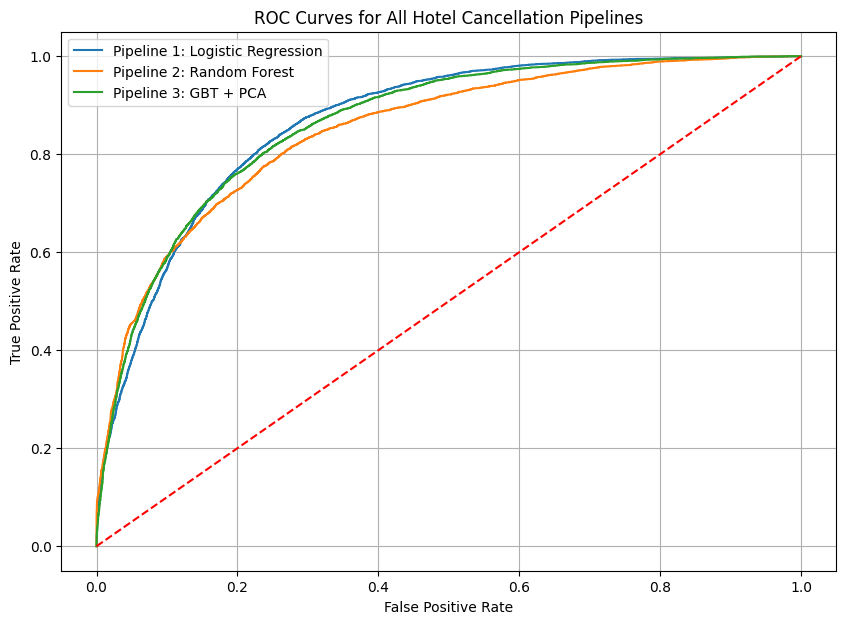

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

pipelines = [
    ("Pipeline 1: Logistic Regression", predictions1),
    ("Pipeline 2: Random Forest",       predictions2),
    ("Pipeline 3: GBT + PCA",           predictions4),
]

for name, pred_df in pipelines:
    # True labels
    y_true = [row.is_canceled for row in pred_df.select("is_canceled").collect()]

    # Scores = P(class = 1) from probability vector
    y_score = []
    for row in pred_df.select("probability").collect():
        vec = row.probability
        prob1 = float(vec[1]) if hasattr(vec, "__getitem__") else float(vec)
        y_score.append(prob1)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=name)

# Diagonal baseline
plt.plot([0, 1], [0, 1], 'r--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Hotel Cancellation Pipelines")
plt.legend()
plt.grid(True)
plt.show()
